In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [ ]:
#!pip install mediapipe

In [10]:
# import libraries
import tensorflow as tf
import cv2
import numpy as np
import os
from tensorflow import keras
from matplotlib import pyplot as plt
import time 
import mediapipe as mp

## Keypoints using mediapipe Holistic

In [ ]:
# create variables for mediapipe holistic

mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities


In [17]:
'''
 in order to make a detection with mediapipe, we first need to convert the image from bgr to rgb
 and then set it to unwritable so it saves a little bit of memory then make our detection
 and then set it back to writable and then convert it from rgb to bgr
 
'''

def mediapipe_detection(image,model):
    #pass
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # color conversion BGR 2 RGB
    image.flags.writeable= False  # image is no longer writable
    results=model.process(image)  # make prediction
    image.flags.writeable=True     # image is now writable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # color conversion RGB 2 BGR
    return image, results

In [77]:
def draw_styled_landmarks(image, results):
    #Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1), #the color is in bgr
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)) 
    #Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2))
    #Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2))
    #Draw right hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2))


In [78]:
cap = cv2.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #read frame
        ret,frame = cap.read()

        #Make prediction
        image,results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)

        #show to screen
        cv2.imshow('OpenCV Feed', image)

        #break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release() 
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

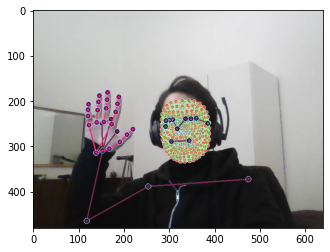

In [81]:
# apply landmarks to the frame

draw_styled_landmarks(frame,results)

plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

## Extract keypoint values

In [90]:
results.pose_landmarks.landmark[0]

x: 0.49837106466293335
y: 0.5441331267356873
z: -0.7218843698501587
visibility: 0.999951183795929

In [133]:
results.face_landmarks.landmark[0]

x: 0.5180341005325317
y: 0.5996814370155334
z: -0.023906851187348366

In [129]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    left_hand = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

    right_hand = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    
    # concatenate face pose, left_h and right_h
    return np.concatenate([pose,face,right_hand,left_hand])


## Setup Folders for collection

In [146]:
# setting folders for array collection

# path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# actions to detect
actions=np.array(['Hello','thanks','iloveyou'])

no_sequences = 30 #30 videos worth of data

sequence_length=30 #videos are going to be 30 frames in length

In [148]:
#create folders where we're going to store the data

for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass
        

## Collect Keypoint Values for Training and Testing

In [150]:
cap = cv2.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    
    #Loop though actions
    for action in actions:
        # loop through sequences aka videos
        for sequence in range(no_sequences):
            #loop through video length aka sequence length
            for frame_num in range(sequence_length):

                #read frame
                ret,frame = cap.read()

                #Make prediction
                image,results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Apply wait logic, essentially have a break after each 30 sequence collection
                if frame_num == 0:
                    cv2.putText(image,'STARTING COLLECTION', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'COLLECTING frames for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

                    cv2.waitKey(2000) #2 sec break between each video
                else:
                    cv2.putText(image,'COLLECTING frames for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    
                    #show to screen
                    cv2.imshow('OpenCV Feed', image)

                # export keypoints
                keypoints=extract_keypoints(results)
                npy_path=os.path.join(DATA_PATH,action,str(sequence),str(frame_num)) #save frame name to the specific name
                np.save(npy_path,keypoints)
                
                
                #break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release() 
    cv2.destroyAllWindows()
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

## Pre-process Data : Create Labels and Features

In [151]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [153]:
# to represent each of our actions
label_map = {label:num for num, label in enumerate(actions)}

In [154]:
label_map

{'Hello': 0, 'thanks': 1, 'iloveyou': 2}

In [159]:
sequences, labels = [], [] #sequences : feature data
for action in actions:
    for sequence in range(no_sequences):
        window=[] # all the different frames we've got for each sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
            window.append(res) #add each frame to the window
        sequences.append(window) # add the videos to the sequence
        labels.append(label_map[action])

In [164]:
y = to_categorical(labels).astype(int)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

## Build and Train LSTM model

In [192]:
from tensorflow.keras.models import Sequential #allows us to build a sequential NN
from tensorflow.keras.layers import LSTM, Dense 
# LSTM gives us a temporal component to build a NN and allows us to perform action detection
#Dense normal fully connected layer
from tensorflow.keras.callbacks import TensorBoard #trace and monitor

In [193]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [203]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu', input_shape=(30,1662)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(32,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax')) #softmax probability [0,1] and the sum of all equals to 1


In [195]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])


In [196]:
#fit and train model
#epochs depending on the amount of the data
model.fit(X_train,y_train, epochs=500,callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 4s 373ms/step - loss: 1.1572 - categorical_accuracy: 0.3765
Epoch 2/500
3/3 [==============================] - 1s 356ms/step - loss: 49.7777 - categorical_accuracy: 0.3294
Epoch 3/500
3/3 [==============================] - 1s 371ms/step - loss: 48.8318 - categorical_accuracy: 0.3412
Epoch 4/500
3/3 [==============================] - 1s 376ms/step - loss: 20.6191 - categorical_accuracy: 0.3059
Epoch 5/500
3/3 [==============================] - 1s 392ms/step - loss: 21.6438 - categorical_accuracy: 0.3176
Epoch 6/500
3/3 [==============================] - 1s 374ms/step - loss: 20.1007 - categorical_accuracy: 0.3059
Epoch 7/500
3/3 [==============================] - 1s 361ms/step - loss: 37.5811 - categorical_accuracy: 0.3176
Epoch 8/500
3/3 [==============================] - 1s 364ms/step - loss: 18.9667 - categorical_accuracy: 0.3647
Epoch 9/500
3/3 [==============================] - 1s 363ms/step - loss: 27.1541 - categorical_accuracy: 

KeyboardInterrupt: 

In [188]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 32)                20608     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 565,827
Trainable params: 565,827
Non-tr

In [197]:
res = model.predict(X_test)

In [198]:
actions[np.argmax(res[4])]

'Hello'

In [199]:
actions[np.argmax(y_test[4])]

'Hello'

In [200]:
model.save('AD_LSTM_action.h5')

In [201]:
del model

In [204]:
model.load_weights('AD_LSTM_action.h5')

## Evaluating using Confusion Matrix and Accuracy

In [205]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [221]:
yhat = model.predict(X_test)

In [222]:
ytrue=np.argmax(y_test,axis=1).tolist()
yhat=np.argmax(yhat,axis=1).tolist()

In [223]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[4, 0],
        [0, 1]],

       [[4, 0],
        [1, 0]],

       [[1, 1],
        [0, 3]]], dtype=int64)

In [224]:
accuracy_score(ytrue,yhat) # 80%

0.8

## Test in Real Time

In [ ]:
colors = [(245,117,16),(117,245,16),(16,117,245)]

def prob_viz(res,actions,input_frame,colors):
    output_frame=input_frame.copy()
    for num,prob in enumerate(res):
        cv2.rectangle(output_frame,(0,60+num*40),(int(prob*100),90+num*40),colors[num],-1)
        cv2.putText(output_frame,actions[num],(0,85+num*40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        
    return output_frame

In [238]:
# 1. New detection variables
sequence =[]
sentence=[]
predictions=[]
threshold=0.4 #confidence matrix, we only gonna run the results if they're above a certain threshold

# 2. implement a prediction logic, in order to generate a prediction, we need 30 frames of data
# so we will concatenate a data into sequence, then once we've got 30 frames of data we're able to make a detection

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #read frame
        ret,frame = cap.read()

        #Make prediction
        image,results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        #2. Prediction logic
        keypoints=extract_keypoints(results)
        
        #sequence.insert(0,keypoints)
        #sequence=sequence[:30] #last 30 frames
        sequence.append(keypoints)
        sequence=sequence[-30:]
        
        if len(sequence)==30:
            res=model.predict(np.expand_dims(sequence,axis=0))[0] 
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)]  >threshold:
                    if len(sentence) > 0:
                        
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                if len(sentence) > 5:
                    sentence = sentence[-5:] 
                                                               

                # Viz proba
                image = prob_viz(res,action,image,colors)
                cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
                cv2.putText(image,' '.join(sentence),(3,30),
                           cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)



               
                cv2.imshow('OpenCV Feed', image)
               
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release() 
    cv2.destroyAllWindows() 
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

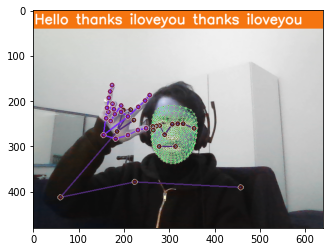

In [239]:
plt.imshow((image))

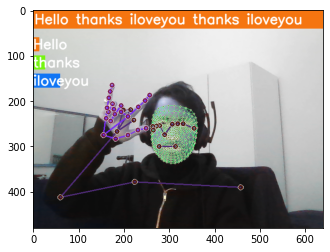

In [240]:
plt.imshow(prob_viz(res,actions,image,colors))